# Задание 1

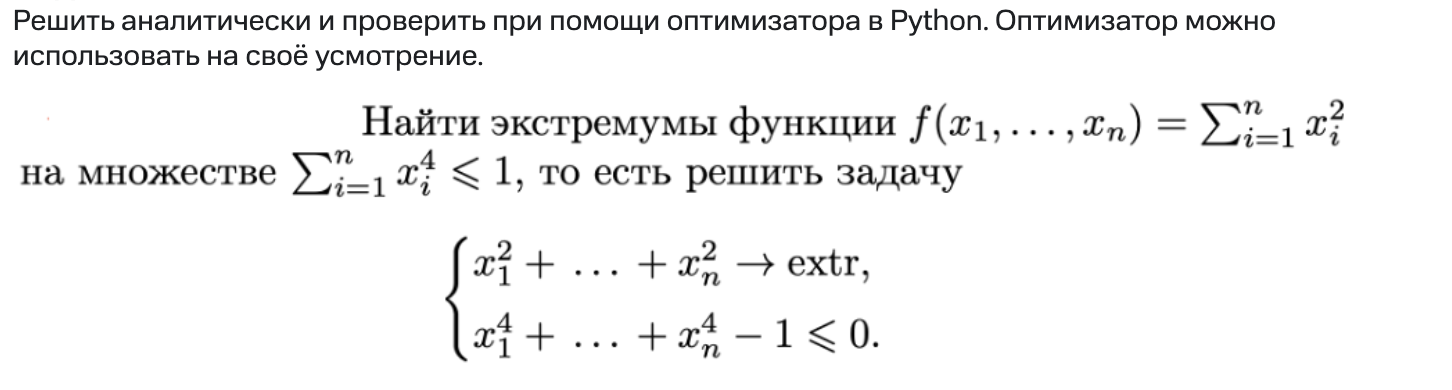

In [22]:
import numpy as np
from scipy.optimize import minimize

# сама функция
def func_opt(x):
    return np.sum(x**2)

# ограничение множества
def constr(x):
    return 1 - np.sum(x**4)

# сколько n?
n = 5

# Сразу задам Нначальное приближение полученное из аналитики (для случая x_i = ±(1/n)^(1/4)), 
# но если задать просто np.random.rand(n), тоже самое будет

x0 = np.sign(np.random.rand(n) - 0.5) * (1/n)**(1/4)

# ограничение для scipy
cons_ineq = {'type': 'ineq', 'fun': constr}

# ищу минимум
res_min = minimize(func_opt, x0, method='SLSQP', constraints=cons_ineq)

# ищу максимум
res_max = minimize(lambda x: -func_opt(x), x0, method='SLSQP', constraints=cons_ineq)

print("Минимальные значения x:", res_min.x)
print("Минимальное значение функции:", res_min.fun)
print("Значение ограничения (<= 1):", np.sum(res_min.x**4))

print("\nМаксимальные значения x:", res_max.x)
print("Максимальное значение функции:", -res_max.fun)
print("Значение ограничения (= 1):", np.sum(res_max.x**4))


Минимальные значения x: [-1.11022302e-16 -1.11022302e-16  1.11022302e-16 -1.11022302e-16
  1.11022302e-16]
Минимальное значение функции: 6.162975822039155e-32
Значение ограничения (<= 1): 7.596454196607839e-64

Максимальные значения x: [ 0.6687403  0.6687403 -0.6687403  0.6687403 -0.6687403]
Максимальное значение функции: 2.23606797749979
Значение ограничения (= 1): 0.9999999999999999


# Задание 2

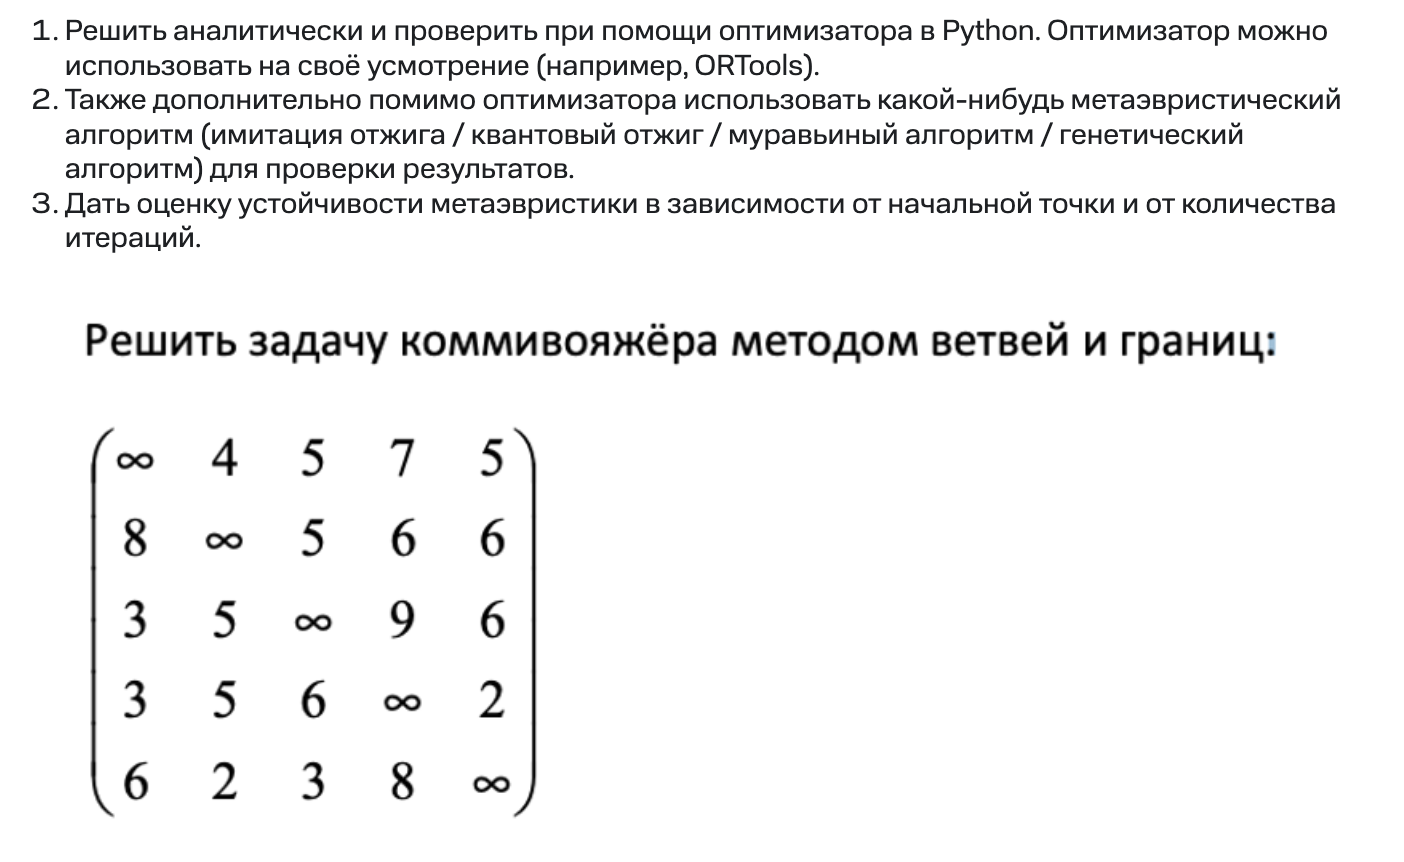

Возьму код отсюда: https://colab.research.google.com/github/google/or-tools/blob/stable/examples/notebook/constraint_solver/tsp.ipynb?hl=ru#scrollTo=code

Но поменяю в нем:

1) координаты на матрицу
2) уберу Манхеттенскую метрику

In [29]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        [float('inf'), 4, 5, 7, 5],
        [8, float('inf'), 5, 6, 6],
        [3, 5, float('inf'), 9, 6],
        [3, 5, 6, float('inf'), 2],
        [6, 2, 3, 8, float('inf')]
    ]
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data

def print_solution(manager, routing, assignment):
    """Prints assignment on console."""
    print(f"Objective: {assignment.ObjectiveValue()}")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    plan_output += f"Distance of the route: {route_distance}\n"
    print(plan_output)

def main():
    """Entry point of the program."""
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        print_solution(manager, routing, assignment)

main()


Objective: 18
Route for vehicle 0:
 0 -> 1 -> 3 -> 4 -> 2 -> 0
Distance of the route: 18



# Задание 2. Часть 2. Решу с помощью метаэвристического алгоритма "Имитация отжига". Дам оценку устойчивости метаэвристики (имитация отжига) в зависимости от начальной точки и от количества итераций

Видоизменю код по аналогии с кодом выше для реализации метаэвристического алгоритма  - **имитация отжига** 

Результаты получились аналогичные (кроме момента, что из 2 не возвращается в ноль)

Initial points stability - Mean distance: 18.0, Std dev: 0.0
Run 1 - Route: 0 -> 1 -> 3 -> 4 -> 2 with distance: 18
Run 2 - Route: 0 -> 1 -> 3 -> 4 -> 2 with distance: 18
Run 3 - Route: 0 -> 1 -> 3 -> 4 -> 2 with distance: 18
Run 4 - Route: 0 -> 1 -> 3 -> 4 -> 2 with distance: 18
Run 5 - Route: 0 -> 1 -> 3 -> 4 -> 2 with distance: 18
Run 6 - Route: 0 -> 1 -> 3 -> 4 -> 2 with distance: 18
Run 7 - Route: 0 -> 1 -> 3 -> 4 -> 2 with distance: 18
Run 8 - Route: 0 -> 1 -> 3 -> 4 -> 2 with distance: 18
Run 9 - Route: 0 -> 1 -> 3 -> 4 -> 2 with distance: 18
Run 10 - Route: 0 -> 1 -> 3 -> 4 -> 2 with distance: 18


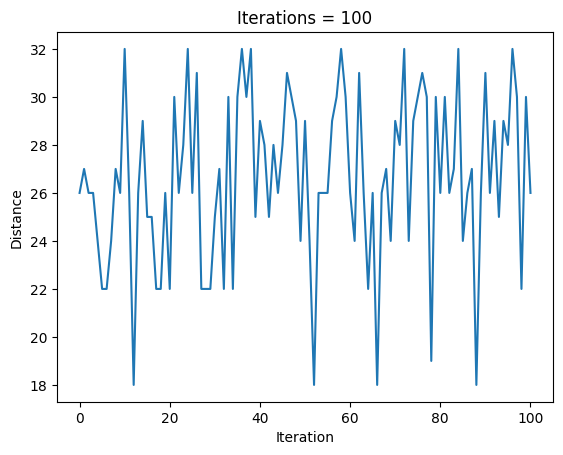

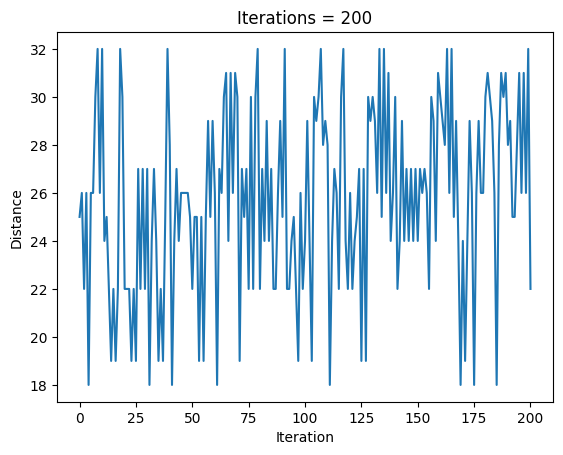

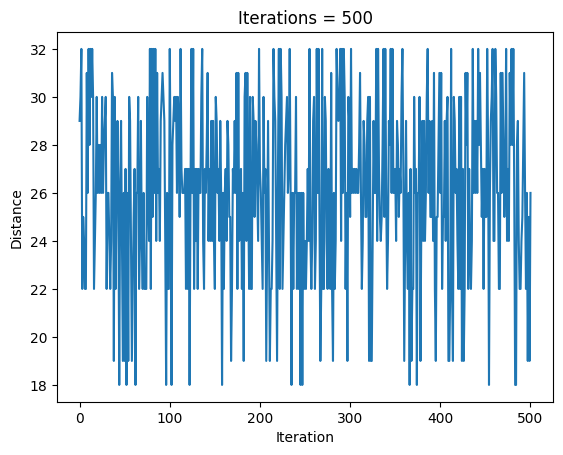

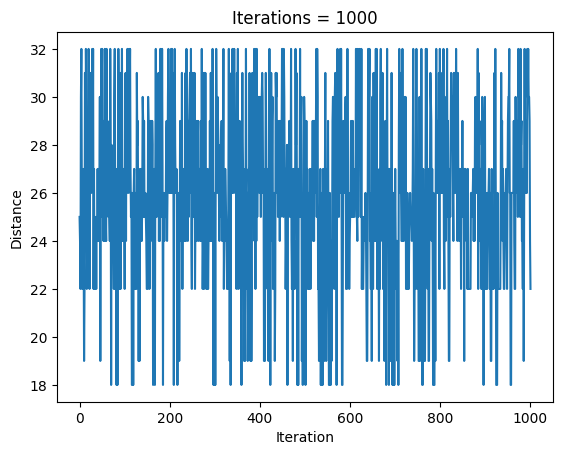

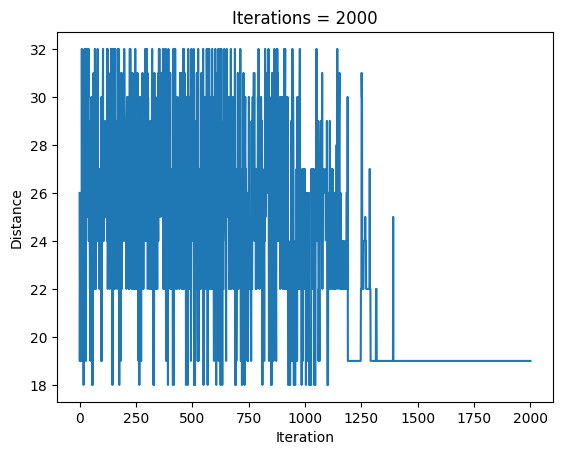

In [37]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        [float('inf'), 4, 5, 7, 5],
        [8, float('inf'), 5, 6, 6],
        [3, 5, float('inf'), 9, 6],
        [3, 5, 6, float('inf'), 2],
        [6, 2, 3, 8, float('inf')]
    ]
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data

def calculate_total_distance(route, distance_matrix):
    """Calculates the total distance of a given route."""
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i]][route[i + 1]]
    total_distance += distance_matrix[route[-1]][route[0]]  # Return to depot
    return total_distance

def generate_neighborhood(route):
    """Generates a new route by swapping two cities."""
    new_route = route[:]
    i, j = random.sample(range(1, len(route)), 2)
    new_route[i], new_route[j] = new_route[j], new_route[i]
    return new_route

def simulated_annealing(data, initial_route=None, max_iterations=1000):
    """Solves the VRP using Simulated Annealing."""
    if initial_route is None:
        # Initialize the solution: start with a random route (excluding depot).
        route = list(range(1, len(data["distance_matrix"])))
        random.shuffle(route)
        route = [data["depot"]] + route  # Add depot at the beginning
    else:
        route = initial_route

    # Set initial temperature and cooling rate.
    temperature = 1000
    cooling_rate = 0.995

    current_distance = calculate_total_distance(route, data["distance_matrix"])
    best_route = route[:]
    best_distance = current_distance

    distances = [current_distance]  # For plotting progress

    # Annealing process.
    for _ in range(max_iterations):
        # Generate a neighboring solution.
        neighbor = generate_neighborhood(route)
        neighbor_distance = calculate_total_distance(neighbor, data["distance_matrix"])

        # Decide if we should accept the new solution.
        if neighbor_distance < current_distance:
            route = neighbor
            current_distance = neighbor_distance
            if current_distance < best_distance:
                best_route = route[:]
                best_distance = current_distance
        else:
            # Accept worse solutions with a certain probability.
            acceptance_probability = math.exp((current_distance - neighbor_distance) / temperature)
            if random.random() < acceptance_probability:
                route = neighbor
                current_distance = neighbor_distance

        # Cool down the temperature.
        temperature *= cooling_rate
        distances.append(current_distance)

    return best_route, best_distance, distances

def print_solution(route, total_distance):
    """Print the route and its distance."""
    route_str = " -> ".join(map(str, route))
    print(f"Route: {route_str}")
    print(f"Total distance: {total_distance}")

def plot_results(distances, title):
    """Plots the distance reduction over iterations."""
    plt.plot(distances)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Distance")
    plt.show()

# начальная точка

def evaluate_initial_points(data, num_runs=10, max_iterations=1000):
    """Evaluates stability depending on the initial random solutions."""
    distances = []
    all_routes = []
    for _ in range(num_runs):
        best_route, best_distance, _ = simulated_annealing(data, max_iterations=max_iterations)
        distances.append(best_distance)
        all_routes.append(best_route)
    
    print(f"Initial points stability - Mean distance: {np.mean(distances)}, Std dev: {np.std(distances)}")
    
    # Print routes for each run
    for i, route in enumerate(all_routes):
        print(f"Run {i+1} - Route: {' -> '.join(map(str, route))} with distance: {distances[i]}")

    return distances

# кол - во итераций
def evaluate_iterations(data, max_iterations_list=[100, 200, 500, 1000, 2000]):
    """Evaluates stability depending on the number of iterations."""
    results = {}
    for max_iter in max_iterations_list:
        _, _, distances = simulated_annealing(data, max_iterations=max_iter)
        results[max_iter] = distances
        plot_results(distances, f"Iterations = {max_iter}")
    
    return results

data = create_data_model()

# начальная точка
initial_stability = evaluate_initial_points(data)

# кол - во итераций
iteration_stability = evaluate_iterations(data)


В результате получилось, что:

1) Алгоритм очень устойчив к изменению начальной точки (случайной перестановки маршрута). По среднему расстоянию (всегда 18) и значению стандартного отклонения (0) видно, что алгоритм всегда приходил к одному и тому же решению, результаты стабильно повторяются и не зависят от случайных факторов на старте.

2) Про стабильность итераций:

Когда количество итераций растет, температура в алгоритме падает, и вероятность того, что он примет плохое решение, становится меньше. Алгоритм начинает стабилизироваться и находить лучшее решение, что видно по уменьшению колебаний на графике.

После 2000 итераций значения расстояния становятся более стабильными и на графике образуется плато. Это значит, что дальнейшие итерации не приводят к заметным улучшениям. Алгоритм уже нашел хорошее решение, и увеличение числа итераций не улучшит результат.